In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os, sys
opj = os.path.join
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
import transform_wrappers
sys.path.append('../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from torch import nn
from style import *
from numpy.fft import *
from captum.attr import *
from knockout import *
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../..')
from acd_wooseok.acd.scores import cd, score_funcs, cd_propagate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# set args
args = dset.get_args()

# load mnist data
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# freq band
band_centers = np.linspace(0.15, 0.85, 20)
band_center_idx = 7
band_width = 0.05

# test model
model = Net2c().to(device)
model.load_state_dict(torch.load(opj('models/freq','net2c_' + str(band_center_idx) + '.pth'), map_location=device))

# test model
transformer = lambda x: transform_bandpass(x, band_centers[band_center_idx], band_width)
test_loss, correct = test_Net2c(test_loader, model, transformer)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, 2*len(test_loader.dataset),
    100. * correct / (2*len(test_loader.dataset))))  

10it [00:03,  2.59it/s]


Test set: Average loss: 0.0000, Accuracy: 20000/20000 (100%)


# scores in fft space

In [21]:
def get_attributions(x_t: torch.Tensor, mt, class_num=1, device='cuda'):
    '''Returns all scores in a dict assuming mt works with both grads + CD

    Params
    ------
    mt: model
    class_num: target class
    '''
    x_t = x_t.to(device)
    x_t.requires_grad = True
    mt = mt.to(device)
    mt.eval()

    results = {}
    attr_methods = ['IG', 'DeepLift', 'SHAP', 'CD', 'InputXGradient']
    for name, func in zip(attr_methods,
                          [IntegratedGradients, DeepLift, GradientShap, None, InputXGradient]):

        if name == 'CD':
            with torch.no_grad():
                sweep_dim = 1
                tiles = acd.tiling_2d.gen_tiles(x_t[0,0,...,0], fill=0, method='cd', sweep_dim=sweep_dim)
                if x_t.shape[-1] == 2: # check for imaginary representations
                    tiles = np.repeat(np.expand_dims(tiles, axis=-1), repeats=2, axis=3).squeeze()
                tiles = torch.Tensor(tiles).unsqueeze(1)
                attributions = acd.get_scores_2d(mt, method='cd', ims=tiles, im_torch=x_t)[..., class_num].T.reshape(-1,28,28)
#                 attributions = score_funcs.get_scores_2d(mt, method='cd', ims=tiles, im_torch=x_t)[..., class_num].T.reshape(-1,28,28)
        else:
            baseline = torch.zeros(x_t.shape).to(device)
            attributer = func(mt)
            if name in ['InputXGradient']:
                attributions = attributer.attribute(deepcopy(x_t), target=class_num)
            else:
                attributions = attributer.attribute(deepcopy(x_t), deepcopy(baseline), target=class_num)
            attributions = attributions.cpu().detach().numpy().squeeze()
            if x_t.shape[-1] == 2: # check for imaginary representations
                attributions = mag(attributions)
        results[name] = attributions
    return results    

In [36]:
# FFT
t = lambda x: torch.fft(torch.stack((x, torch.zeros_like(x)),dim=4) , 2)
transform_i = transform_wrappers.modularize(lambda x: torch.ifft(x, 2)[...,0])

# test data
x, _ = iter(test_loader).next()
x = x.to(device)[0:10]
x_t = t(x).to(device)

m_t = transform_wrappers.Net_with_transform(model=model, transform=transform_i).to(device)
m_t.eval()

# get interp scores
attr_methods = ['IG', 'DeepLift', 'SHAP', 'CD', 'InputXGradient']
results = get_attributions(x_t, m_t, class_num=1)

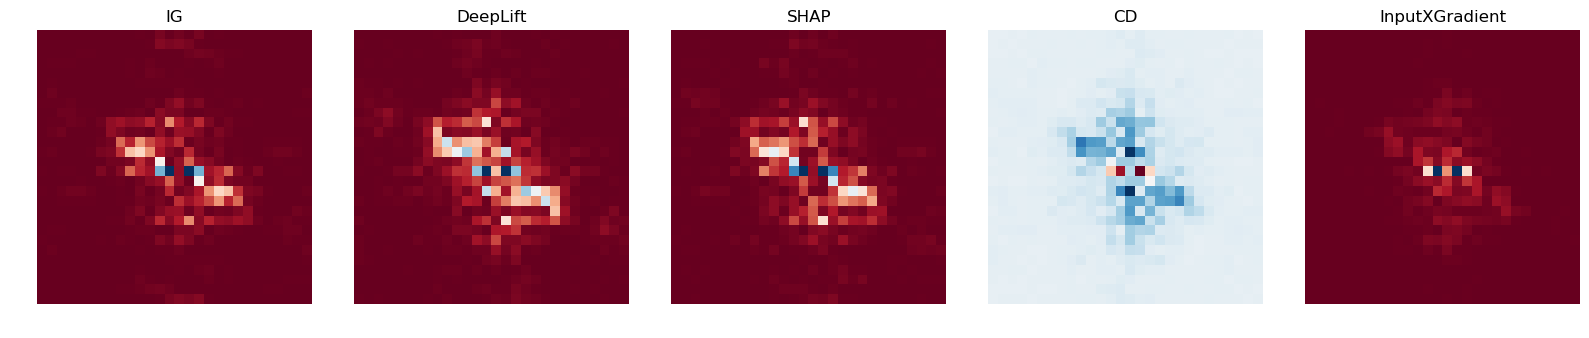

In [37]:
obs_idx = 1
plt.figure(figsize=(16, 5),dpi=100)
for i, name in enumerate(attr_methods):
    interp_scores = fftshift(results[name][obs_idx])
    plt.subplot(1, 5, i + 1)
    plt.imshow(interp_scores, cmap='RdBu')
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [38]:
freq_arr = fftshift(fftfreq(n=28))
freq_arr /= np.max(np.abs(freq_arr))
mask_bandpass = torch.zeros(x_t.shape[2:4])

for r in range(x_t.shape[2]):
    for c in range(x_t.shape[3]):
        dist = np.sqrt(freq_arr[r]**2 + freq_arr[c]**2)
        if dist > band_center - band_width / 2 and dist < band_center + band_width / 2:
            mask_bandpass[r, c] = 1

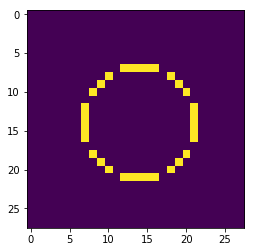

In [39]:
plt.imshow(mask_bandpass)
plt.show()